In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [2]:
import zipfile

zip_path = "/content/homework.zip"
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Розпаковано:", extract_path)

Розпаковано: /content/dataset


In [3]:
import os
os.listdir("/content/dataset/data")

['stairs', 'running', 'walking', 'idle']

In [4]:

os.listdir("/content/dataset/data/walking")[:5]

['walking-623.csv',
 'walking-1068.csv',
 'walking-1252.csv',
 'walking-1128.csv',
 'walking-9.csv']

In [5]:
# Читаємо один csv
import pandas as pd
import numpy as np
folder = "/content/dataset/data/walking"
file_name = os.listdir(folder)[0]
file_path = os.path.join(folder, file_name)
df = pd.read_csv(file_path)
df



,accelerometer_X,accelerometer_Y,accelerometer_Z
0,-0.780510,-6.009446,-11.377247
1,-2.853888,-10.860099,-5.137956
2,-5.061342,-7.967903,-8.298302
3,-3.639186,-8.030152,1.450886
4,-3.691859,-5.094861,-1.800440
5,-6.258443,-8.585608,-1.000776
6,-6.426037,-13.819332,-3.371036
7,-3.567361,-5.233725,-7.666234
8,-7.201759,-7.479486,-2.197877
9,-2.753332,-4.486734,0.167594


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   accelerometer_X  30 non-null     float64
 1   accelerometer_Y  30 non-null     float64
 2   accelerometer_Z  30 non-null     float64
dtypes: float64(3)
memory usage: 852.0 bytes


In [7]:
# Функція для розрахунку ознак для кожної осі акселерометра(time-domain features) для одного DataFrame
def extract_features(df):
    features = {} # словник для зберігання нових ознак (features) для одного файла CSV

    for axis in ["accelerometer_X", "accelerometer_Y", "accelerometer_Z"]:
        data = df[axis]
        features[f"{axis}_mean"] = data.mean()
        features[f"{axis}_std"] = data.std()
        features[f"{axis}_min"] = data.min()
        features[f"{axis}_max"] = data.max()
        features[f"{axis}_rms"] = np.sqrt(np.mean(data**2))
        features[f"{axis}_range"] = data.max() - data.min()

    # Кореляції між осями
    features["corr_XY"] = df["accelerometer_X"].corr(df["accelerometer_Y"])
    features["corr_XZ"] = df["accelerometer_X"].corr(df["accelerometer_Z"])
    features["corr_YZ"] = df["accelerometer_Y"].corr(df["accelerometer_Z"])

    return features # повертаємо строку ознак


In [8]:
# Шлях до датасету
DATA_PATH = "/content/dataset/data"
# Список класів
classes = ["idle", "running", "stairs", "walking"]

In [9]:
# Збір всіх ознак і міток
feature_list = []
label_list = []

for cls in classes:
    folder = os.path.join(DATA_PATH, cls)
    files = [f for f in os.listdir(folder) if f.endswith(".csv")]

    for file in files:
        df = pd.read_csv(os.path.join(folder, file))
        features = extract_features(df)
        feature_list.append(features)
        label_list.append(cls)

In [10]:
# Формуємо ознаки
X = pd.DataFrame(feature_list)
y = pd.Series(label_list) # цільова змінна( 4 класи : idle, running, stairs, walking )


print("Ознаки:", X.shape)
print("Мітки:", y.shape)
print("---------------")
print(y.value_counts()) # кількість прикладів по классам

X


Ознаки: (6462, 21)
Мітки: (6462,)
---------------
running    3408
walking    1850
idle       1039
stairs      165
Name: count, dtype: int64


,accelerometer_X_mean,accelerometer_X_std,accelerometer_X_min,accelerometer_X_max,accelerometer_X_rms,accelerometer_X_range,accelerometer_Y_mean,accelerometer_Y_std,accelerometer_Y_min,accelerometer_Y_max,...,accelerometer_Y_range,accelerometer_Z_mean,accelerometer_Z_std,accelerometer_Z_min,accelerometer_Z_max,accelerometer_Z_rms,accelerometer_Z_range,corr_XY,corr_XZ,corr_YZ
0,0.407972,0.034722,0.330400,0.488417,0.409398,0.158017,-0.028411,0.037089,-0.105345,0.057461,...,0.162806,9.755255,0.015953,9.730036,9.787497,9.755267,0.057461,-0.398087,0.114756,-0.099591
1,-0.234951,2.054302,-9.054871,5.650316,2.033393,14.705187,2.745192,2.947002,-2.264915,6.708554,...,8.973469,9.189425,2.641046,6.392519,21.988348,9.549249,15.595829,-0.213506,-0.629348,-0.472355
2,0.238622,0.126496,-0.215478,0.349553,0.269088,0.565031,0.036711,1.154637,-2.284068,5.741296,...,8.025364,9.555419,0.765069,6.133945,9.868899,9.584980,3.734954,0.249748,0.932240,0.204282
3,0.219469,0.590283,-1.728614,2.341529,0.620473,4.070143,0.438299,1.702251,-0.995988,6.904878,...,7.900866,9.625808,0.669446,6.502652,10.515334,9.648285,4.012682,-0.304023,0.254334,-0.945312
4,-0.352586,0.302590,-0.976834,0.105345,0.461331,1.082179,5.449044,0.388091,4.505888,6.258444,...,1.752556,7.847395,0.390893,7.010223,9.006987,7.856801,1.996764,0.265153,0.144872,-0.385860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6457,-4.067270,3.551569,-11.243171,5.544971,5.360585,16.788142,-9.960517,6.228132,-20.547040,9.351752,...,29.898792,0.602381,6.952421,-16.338032,24.660278,6.862056,40.998310,0.443582,0.352359,0.550297
6458,-4.320736,3.993748,-15.088259,4.141969,5.838417,19.230228,-9.659965,4.084106,-17.980455,-1.470040,...,16.510415,-0.793758,6.834219,-14.695610,17.712305,6.766070,32.407915,0.465372,0.333849,0.318414
6459,-3.457546,3.455019,-10.500969,4.141969,4.847049,14.642938,-9.331002,5.256709,-17.137695,6.928820,...,24.066515,-0.953052,8.880446,-26.853367,17.712305,8.783046,44.565672,-0.042823,0.558276,-0.114728
6460,-2.282632,3.867431,-11.650186,5.013459,4.434959,16.663645,-9.365638,6.493952,-26.695349,1.086968,...,27.782317,-1.694616,4.087408,-11.650186,3.548207,4.361391,15.198393,0.455124,0.021157,0.093256


In [11]:
# train-test-split
from sklearn.model_selection import train_test_split

# X — ознаки, y — мітки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [12]:
# візьмемо дві характеристики mean и std (середнє прискорення по осі та розкид сигналу )
mean_std_features = ['accelerometer_X_mean','accelerometer_X_std',
                'accelerometer_Y_mean','accelerometer_Y_std',
                'accelerometer_Z_mean','accelerometer_Z_std']
X_train_mean_std = X_train[mean_std_features]
X_test_mean_std  = X_test[mean_std_features]

In [13]:
# порівнюємо алгоритм SVM для класифікації та Random Forest  за двома ознаками mean и std

# SVM з масштабуванням
svm_pipeline_1 = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=10, gamma='scale'))
])
# Навчаємо модель на даних для тренування
svm_pipeline_1.fit(X_train_mean_std, y_train)

y_pred_svm_1 = svm_pipeline_1.predict(X_test_mean_std)

# Random Forest
rf_model_1 = RandomForestClassifier(n_estimators=200, random_state=42)
# Навчаємо модель на даних для тренування
rf_model_1.fit(X_train_mean_std, y_train)
# Робимо передбачення та оцінюємо якість моделі(наскільки добре модель позділяє приклади по класам) на даних для тестування
y_pred_rf_1 = rf_model_1.predict(X_test_mean_std)


In [14]:
# Порівнння SVM i Random Forest за допомогою метрик із classification_report
print("=== SVM з mean/std ===")
print(classification_report(y_test, y_pred_svm_1))
print("Точність:", accuracy_score(y_test, y_pred_svm_1))

print("=== Random Forest з mean/std ===")
print(classification_report(y_test, y_pred_rf_1))
print("Точність:", accuracy_score(y_test, y_pred_rf_1))

=== SVM з mean/std ===
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00       208
     running       1.00      1.00      1.00       682
      stairs       0.79      0.79      0.79        33
     walking       0.98      0.98      0.98       370

    accuracy                           0.99      1293
   macro avg       0.94      0.94      0.94      1293
weighted avg       0.99      0.99      0.99      1293

Точність: 0.9891724671307038
=== Random Forest з mean/std ===
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00       208
     running       1.00      1.00      1.00       682
      stairs       0.93      0.82      0.87        33
     walking       0.98      0.99      0.99       370

    accuracy                           0.99      1293
   macro avg       0.98      0.95      0.97      1293
weighted avg       0.99      0.99      0.99      1293

Точність: 0.9938128383604021


In [23]:
# Підбір оптимальныих параметрів за допомогою GridSearchCV
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
# Сітка параметрів для випадкового лісу
param_grid = {
    "n_estimators": [100],
    "max_depth": [None, 15],  # Максимальна глибина дерева
    "min_samples_leaf": [1, 2], # Мінімальна кількість зразків в листі дерева (листовий вузол)
    "max_features": ["sqrt"] # Скільки характристик дерево бачить при кожному розбитті
}

grid_search = GridSearchCV(
    rf,
    param_grid,
    cv=5,
    scoring="f1_macro",
    verbose=2
)
# Навчання на всіх ознаках
grid_search.fit(X_train, y_train)



Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   1.5s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   1.9s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   1.9s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   2.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, n_estimators=100; total time=   1.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=100; total time=   1.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=100; total time=   2.0s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, n_estimators=100; total time=   2.1s
[CV] END max_depth=None, max_fe

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             param_grid={'max_depth': [None, 15], 'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2], 'n_estimators': [100]},
             scoring='f1_macro', verbose=2)

In [24]:
# Random Forest з найкращими параметрами
best_rf = grid_search.best_estimator_
# Прогнозування значень за допомогою найкращої моделі Random Forest
y_pred_rf_best = best_rf.predict(X_test)
print("\nВипадковий ліс з найкращими параметрами:")
print("Найкращі параметри:", grid_search.best_params_)
print(classification_report(y_test, y_pred_rf_best))
print("Точність:", accuracy_score(y_test,y_pred_rf_best))


Випадковий ліс з найкращими параметрами:
Найкращі параметри: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00       208
     running       1.00      1.00      1.00       682
      stairs       0.97      1.00      0.99        33
     walking       1.00      1.00      1.00       370

    accuracy                           1.00      1293
   macro avg       0.99      1.00      1.00      1293
weighted avg       1.00      1.00      1.00      1293

Точність: 0.9992266047950503


In [25]:
# Таблиця порівнянь справжніх і прогнозованих значень класу
comparison = pd.DataFrame({
    "Справжнє значення класу": y_test.values,
    " Прогнозоване значення класу":y_pred_rf_best
})

# 20 випадкових об'єктів
comparison.sample(20)

,Справжнє значення класу,Прогнозоване значення класу
662,running,running
1186,running,running
238,running,running
151,walking,walking
374,walking,walking
1243,idle,idle
755,walking,walking
320,running,running
617,running,running
37,running,running


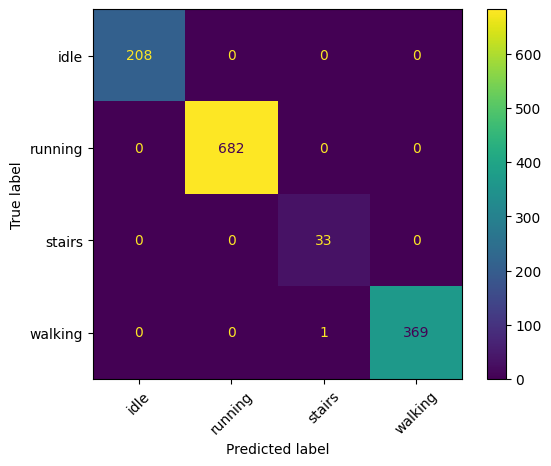

In [26]:
# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(
    best_rf,
    X_test,
    y_test,
    xticks_rotation=45
)

**Висновок:**
1) Було проведено порівняння двох алгоритмів: SVM та Random Forest за двома фічами mean и std (середнє прискорення по осі та розкид сигналу ).Алгоритм з використанням SVM для класифікації продемонстрував гарні результати, але трохи поступився алгоритму Random Forest на менш представлених класах (stairs) по показнику f1-score = 0.79 та f1-score=0.87 відповідно.
2) Після підбору гіперпараметрів за допомогою GridSearchCV модель Random Forest яка навчалася вже на повному наборі ознак (time-domain features) продемонструвала дуже високу якість класифікації на тестовій вибірці. Також суттєво покращились показники якості рідкісного класу stairs (f1-score=0.97) в порінянні з моделями , які використовували алгоритми SVM для класифікації та Random Forest  за двома ознаками mean и std , що свідчить про ефективність використання повного набору ознак (time-domain features)
3) Побудувано confusion matrix (матрицю помилок) яка показує наскільки якісно модель класифікує кожний об'єкт класу.
Майже всі тестові об'єкти були класифіковано вірно.
support - Загальна кількіть тестових прикладів для кожного класу склала:
( idle = 208/208 , running 682/682 , stairs = 33/33 , walking 369/370 )